In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None

In [2]:
order_products_train_df = pd.read_csv("order_products__train.csv")
order_products_prior_df = pd.read_csv("order_products__prior.csv")
orders_df = pd.read_csv("orders.csv")
print("Size of orders", orders_df.shape[0])

products_df = pd.read_csv("products.csv")
print("Size of products", products_df.shape[0])
aisles_df = pd.read_csv("aisles.csv")
print("Size of aisles", aisles_df.shape[0])
departments_df = pd.read_csv("departments.csv")
print("Size of departments", departments_df.shape[0])

Size of orders 3421083
Size of products 49688
Size of aisles 134
Size of departments 21


1. 這次比賽目標就是預測之後顧客會購買的商品！！！
2. 一共有六份資料
    1. prior是用來training，而train是用來做validation，最後有一個是要交出的資料。
    2. 另外有prducts，aisles，departments的資訊。可用來對照。
    3. 還有一個叫做order_id。是每一次購買時的資訊(prior, train, test)。

## orders_df

In [3]:
print(orders_df.shape)
orders_df.head(11)

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


1. 在eval_set中
    1. 每一個user的前面都是prior，然後最後一個order都是training或testing  
    2. 應該就是對應prior_df, training_df, testing_df(我們要交的！)
2. 後面幾個欄位就是購買的星期, 時間以及離上次幾天，我猜NaN就是first_order  
3. order_number是指第幾次order。

In [4]:
# Check the number of unique orders and unique products
orders_Unique = len(set(orders_df.order_id))
user_Unique = len(set(orders_df.user_id))
print("There are %s orders for %s user" %(orders_Unique, user_Unique))

There are 3421083 orders for 206209 user


> 可以知道我們一共有206209個users，有些在training有些在testing...

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64


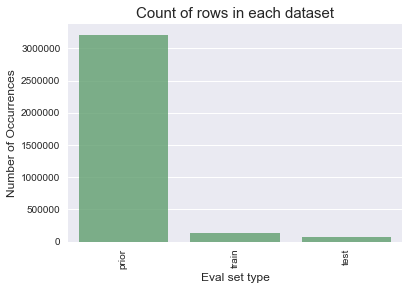

In [32]:
cnt_srs = orders_df.eval_set.value_counts()
print(cnt_srs)

plt.figure(figsize=(6,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

> eval_set在prior, training以及testing的分佈。

In [6]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
print(cnt_srs)

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64


> 206209個顧客，training有131209個，testing有75000個。

   user_id  order_number
0        1            11
1        2            15
2        3            13
3        4             6
4        5             5


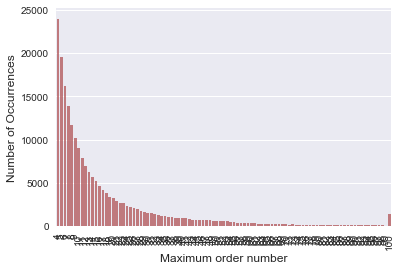

In [33]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
print(cnt_srs.head())
cnt_srs = cnt_srs.order_number.value_counts()
#print(cnt_srs)

plt.figure(figsize=(6,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

> order_number最大數量的分布，100以上應該就為100。

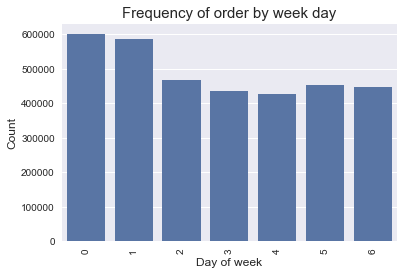

In [34]:
plt.figure(figsize=(6,4))
sns.countplot(x = "order_dow", data = orders_df, color = color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

> 根據星期所產生order_count的分佈。

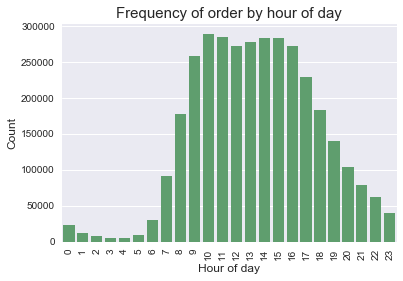

In [35]:
plt.figure(figsize=(6,4))
sns.countplot(x = "order_hour_of_day", data = orders_df, color = color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

> 根據小時所產生order_count的分佈。

   order_dow  order_hour_of_day  order_number
0          0                  0          3936
1          0                  1          2398
2          0                  2          1409
3          0                  3           963
4          0                  4           813


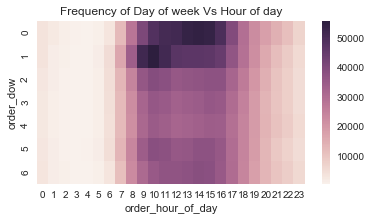

In [36]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
print(grouped_df.head())
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(6,3))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

> 根據小時與星期所產生order_count的分佈。

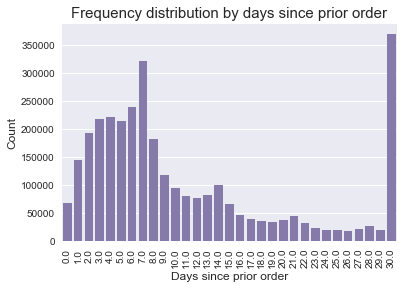

In [37]:
plt.figure(figsize=(6,4))
sns.countplot(x = "days_since_prior_order", data = orders_df, color = color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

> 距離上次購買時間的分佈，我想它30以上應該就記為30。

## order_products_prior_df

In [39]:
print(order_products_prior_df.shape)
order_products_prior_df.head()

(32434489, 16)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,add_to_cart_order_mod,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,2,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,3,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,4,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,5,202279,prior,3,5,9,8.0


1. 根據order_id他可能會一次放入很多商品，有些是reordered有些不是。  
2. 然後根據product_id可以對應商品資訊(departments, aisles)
3. order_id可以對應order的資訊(時間)

In [13]:
# Check the number of unique orders and unique products
orders_Unique = len(set(order_products_prior_df.order_id))
product_Unique = len(set(order_products_prior_df.product_id))
print("There are %s orders for %s product" %(orders_Unique, product_Unique))

There are 3214874 orders for 49677 product


In [14]:
print("percentage of re-orders in prior set :", order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0])


percentage of re-orders in prior set : 0.5896974667922161


In [15]:
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
print(grouped_df.head())
grouped_df["reordered"].ix[grouped_df["reordered"] > 1] = 1
print(grouped_df.head())
grouped_df.reordered.value_counts() / grouped_df.shape[0]

   order_id  reordered
0         2          6
1         3          8
2         4         12
3         5         21
4         6          0
   order_id  reordered
0         2          1
1         3          1
2         4          1
3         5          1
4         6          0


1    0.879151
0    0.120849
Name: reordered, dtype: float64

> 統計這一次的消費中，重複購買商品的數量，以推得這次消費是否唯有目的購買？

   order_id  add_to_cart_order
0         2                  9
1         3                  8
2         4                 13
3         5                 26
4         6                  3
5    228330
6    227675
4    222081
7    220006
3    207027
Name: add_to_cart_order, dtype: int64


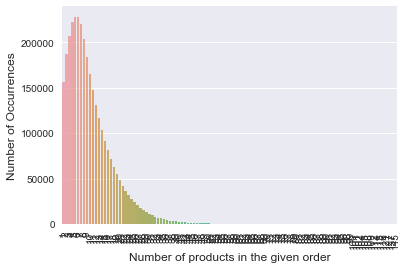

In [40]:
grouped_df = order_products_prior_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
print(grouped_df.head())
cnt_srs = grouped_df.add_to_cart_order.value_counts()
print(cnt_srs.head())

plt.figure(figsize=(6,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha = 0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

> 一次購物放入的賞品數量～

#### merge

In [17]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
print("Size of order_products_prior_df", order_products_prior_df.shape[0])
order_products_prior_df.head()

Size of order_products_prior_df 32434489


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


> 將商品，通路和百貨的資訊合併。

In [41]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index()
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs.head()

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584


> 商品排行榜。

In [42]:
cnt_srs = order_products_prior_df['department'].value_counts().reset_index()
cnt_srs.columns = ['department', 'frequency_count']
cnt_srs["distribution"] = (cnt_srs.frequency_count*100)/sum(cnt_srs.frequency_count)
cnt_srs.head()

,department,frequency_count,distribution
0,produce,9479291,29.225961
1,dairy eggs,5414016,16.692158
2,snacks,2887550,8.902715
3,beverages,2690129,8.294038
4,frozen,2236432,6.895228


> 百貨排行榜。

  department  reordered
0    alcohol   0.569924
1     babies   0.578971
2     bakery   0.628141
3  beverages   0.653460
4  breakfast   0.560922


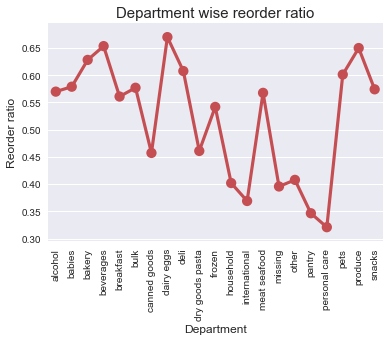

In [43]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()
print(grouped_df.head())

plt.figure(figsize=(6,4))
sns.pointplot(grouped_df['department'].values,
              grouped_df['reordered'].values,
              alpha = 0.8, color = color[2])
plt.ylabel('Reorder ratio', fontsize = 12)
plt.xlabel('Department', fontsize = 12)
plt.title("Department wise reorder ratio", fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

> 百貨與reordered比例的折線圖。

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


     department_id                          aisle  reordered
96              16                           milk   0.781428
38               7  water seltzer sparkling water   0.729593
17               4                   fresh fruits   0.718104
95              16                           eggs   0.705366
100             16                soy lactosefree   0.692551


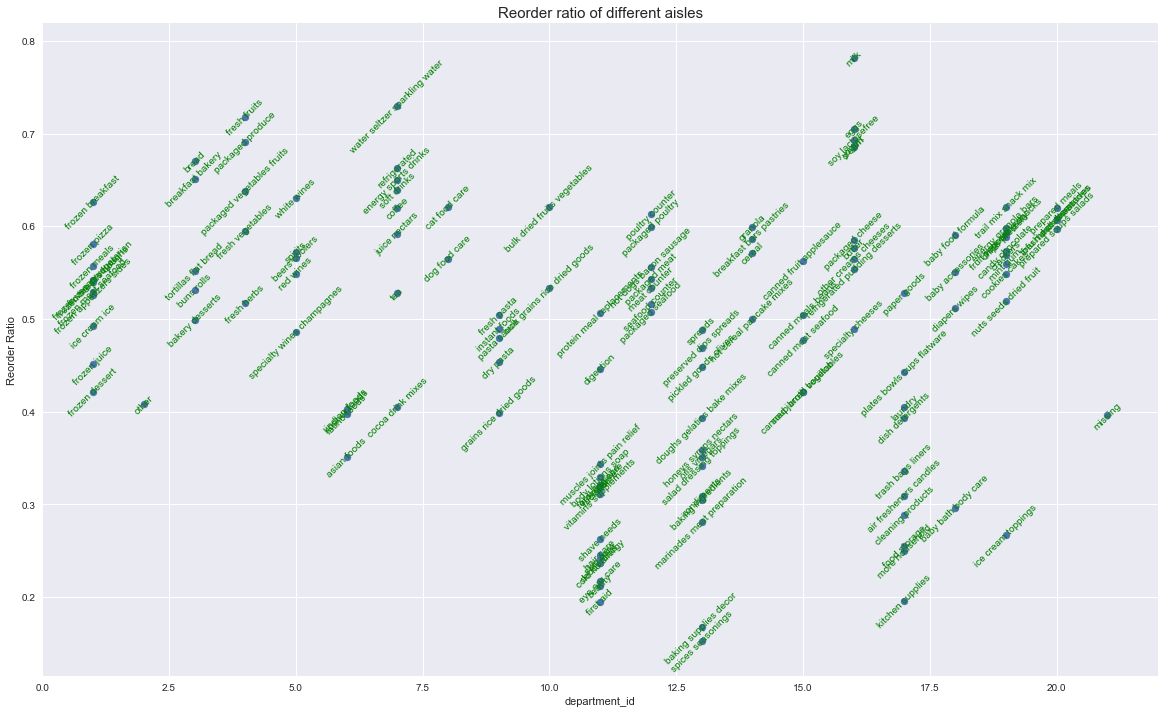

In [21]:
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.sort(columns = "reordered", axis = 0, ascending = False)
print(grouped_df.head())

fig, ax = plt.subplots(figsize=(20,12))
ax.scatter(grouped_df.department_id.values, grouped_df.reordered.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.department_id.values[i], grouped_df.reordered.values[i]),
                rotation = 45, ha = 'center', va = 'center', color = 'green')
plt.xlabel('department_id')
plt.ylabel('Reorder Ratio')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

> 百貨裡面的通路分別被reordered的比例。

   add_to_cart_order_mod  reordered
0                      1   0.677533
1                      2   0.676251
2                      3   0.658037
3                      4   0.636958
4                      5   0.617383


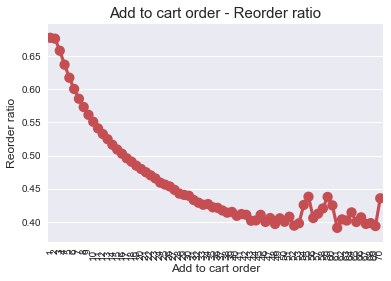

In [52]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].ix[order_products_prior_df["add_to_cart_order_mod"] > 70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()
print(grouped_df.head())

plt.figure(figsize=(6,4))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

> add_to_cart_order的reordered的期望值折線圖，add_to_cart_order70次以上就當作70。